In [249]:
import cspython.match_dataset_creation
from cspython.merging_processing import combine_dfs
dir(cspython.match_dataset_creation)
from cspython.match_dataset_creation import match_dataset_creation
from cspython.match_dataset_creation import aggregate_data_over_time
import cPickle as pkl
from cspython.scraper import modifiedSoup
from cspython.data_processing import process_scrapped
import cPickle as pkl
import sys
sys.setrecursionlimit(15000)

import cspython.analysis as a
import scipy
print('scipy: {}'.format(scipy.__version__)) # numpy
import numpy as np
print('numpy: {}'.format(np.__version__))
# matplotlib


import matplotlib 
import matplotlib.pyplot as plt
print('matplotlib: {}'.format(matplotlib.__version__)) # pandas
import pandas as pd
print('pandas: {}'.format(pd.__version__))
# scikit-learn
#import sklearn
#print('sklearn: {}'.format(sklearn.__version__))
#import xlrd

import seaborn as sns
sns.set_style("whitegrid")
%matplotlib inline


import sklearn
print('sklearn: {}'.format(sklearn.__version__))
#import xlrd
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from sklearn.linear_model import Lasso, Ridge  
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import VotingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.feature_selection import RFE
import xgboost as xgb
from sklearn import cross_validation
from sklearn.model_selection import GridSearchCV
from sklearn import cross_validation #might be model_selection <--- this is the new one
from sklearn.preprocessing import Normalizer
import seaborn as sns
from sklearn import preprocessing 
sns.set_style("whitegrid")
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
import pdb
from sklearn.ensemble import VotingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.feature_selection import RFE
from sklearn import cross_validation
from sklearn.model_selection import GridSearchCV
from sklearn import model_selection
from sklearn.feature_selection import RFECV

scipy: 0.19.1
numpy: 1.12.1
matplotlib: 2.0.2
pandas: 0.20.3
sklearn: 0.19.0


In [250]:
with open('../cspython/esl_teams.pkl', 'rb') as f: 
     d = pkl.load(f)

In [251]:
big_data = process_scrapped(d)
overview, big_data = big_data

In [252]:
data = combine_dfs(overview, big_data)

In [253]:
def round_win_rate_his(data):#gets the historic winning average on each round of each map and combines first half with second half
    round_num = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]
    team = list(data.player_team_name.unique())
    maps = list(data.map.unique())
    fgrouping = pd.DataFrame()
    for a in team:
        data_team = data.loc[data.loc[:,'player_team_name'] == a, ].sort_values(by=['date', 'series_id','match_num'],ascending=True)
        grouping = data_team.groupby(['player_team_name','date','series_id','match_num','match_id','round_num'])['winner'].max()
        grouping = pd.DataFrame(grouping)
        grouping = grouping.reset_index()
        grouping.winner = grouping.winner.replace(to_replace = a, value = 1)
        for c in round_num:
            grouping.loc[:,"round_"+str(c)] = 0
            grouping.loc[(grouping.loc[:,'round_num']== c) & (grouping.loc[:,"winner"] == 1),"round_"+str(c)] = 1
            grouping.loc[(grouping.loc[:,'round_num'] == c+15) & (grouping.loc[:,"winner"] == 1),"round_"+str(c)] = 1
            grouping.loc[(grouping.loc[:,'round_num'] == c) | (grouping.loc[:,'round_num']== c+15),"round_"+str(c)] = grouping.loc[(grouping.loc[:,'round_num'] == c) | (grouping.loc[:,'round_num'] == c+15),"round_"+str(c)].expanding(min_periods=1, freq=None, center=False, axis=0).mean()
        grouping = grouping.groupby(['player_team_name','date','series_id','match_num','match_id']).max()
        grouping = grouping.reset_index()
        grouping = grouping.drop(['round_num','winner'], axis = 1, errors = 'ignore')
        grouping = grouping.fillna(method = 'ffill')

        fgrouping = pd.concat([fgrouping, grouping], axis = 0)

    data = pd.merge(data, fgrouping, on= ['player_team_name','date','series_id','match_num','match_id'])
    return data


In [254]:
def round_win_rate_map_his(data): #gets the historic winning average on each round of each map and combines first half with second half
    round_num = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]
    team = list(data.player_team_name.unique())
    maps = list(data.map.unique())
    fgrouping = pd.DataFrame()
    for a in team:
        data_team = data.loc[data.loc[:,'player_team_name'] == a, ].sort_values(by=['date', 'series_id','match_num'],ascending=True)
        grouping = data_team.groupby(['player_team_name','date','series_id','match_num','match_id','map','round_num'])['winner'].max()
        grouping = pd.DataFrame(grouping)
        grouping = grouping.reset_index()
        grouping.winner = grouping.winner.replace(to_replace = a, value = 1)
        for b in maps:
            for c in round_num:
                grouping.loc[:,b+"_round_"+str(c)] = 0
                grouping.loc[(grouping.loc[:,"map"]== b)&(grouping.loc[:,'round_num']== c) & (grouping.loc[:,"winner"] == 1),b+"_round_"+str(c)] = 1
                grouping.loc[(grouping.loc[:,"map"]== b)&(grouping.loc[:,'round_num']== c+15) & (grouping.loc[:,"winner"] == 1),b+"_round_"+str(c)] = 1
                grouping.loc[(grouping.loc[:,"map"]== b)&(grouping.loc[:,'round_num']== c)|(grouping.loc[:,'round_num']== c+15),b+"_round_"+str(c)] = grouping.loc[(grouping.loc[:,"map"]== b)&(grouping.loc[:,'round_num']== c)|(grouping.loc[:,'round_num']== c+15),b+"_round_"+str(c)].expanding(min_periods=1, freq=None, center=False, axis=0).mean()
        grouping = grouping.groupby(['player_team_name','date','series_id','match_num','match_id']).max()
        grouping = grouping.reset_index()
        grouping = grouping.drop(['round_num','winner'], axis = 1, errors = 'ignore')
        grouping = grouping.fillna(method='ffill')

        fgrouping = pd.concat([fgrouping, grouping], axis = 0)

    data = pd.merge(data, fgrouping, on= ['player_team_name','date','series_id','match_num','match_id','map'])
    return data

In [392]:
def win_previous_map(data): # did they win their previous match on this map
    maps = list(data.map.unique())
    team = list(data.player_team_name.unique())
    fgrouping = pd.DataFrame()
    for a in team:
        for b in maps:
            try: 
                data_team = data.loc[(data.loc[:,'player_team_name'] == a)&(data.loc[:, 'map']==b), ].sort_values(by=['date', 'series_id','match_num'],ascending=True)
                grouping = data_team.groupby(['player_team_name','date','series_id','match_num','map','match_id'])['winner_of_match'].max()
                grouping = pd.DataFrame(grouping)
                grouping = grouping.reset_index()
                grouping.loc[:,"win_previous_map"] = np.nan
                grouping.loc[(grouping.loc[:,'winner_of_match']==a)&(grouping.loc[:, 'map']==b),"win_previous_map"] = 1
                grouping.loc[(grouping.loc[:,'winner_of_match']!=a)&(grouping.loc[:, 'map']==b),"win_previous_map"] = 0
                fgrouping = pd.concat([fgrouping, grouping], axis = 0)
            except:
                pass
    fgrouping = fgrouping.drop(['winner_of_match'], axis = 1, errors = 'ignore')    
    data = pd.merge(data, fgrouping, on= ['player_team_name','date','series_id','match_num','map','match_id'])
    return data

In [393]:
def win_previous_team(data): #did they win their previous match against this team / impliment after match_dataset_creation
    team = list(data.player_team_name.unique())
    opponent = list(data.player_team_opponent.unique())
    fgrouping = pd.DataFrame()
    for a in team:
        for b in opponent:
            try:
                data_team = data.loc[(data.loc[:,'player_team_name'] == a) & (data.loc[:,'player_team_opponent'] == b), ].sort_values(by=['date', 'series_id','match_num'],ascending=True)
                grouping = data_team.groupby(['player_team_name','date','series_id','match_num','player_team_opponent','match_id'])['winner_of_match'].max()
                grouping = pd.DataFrame(grouping)
                grouping = grouping.reset_index()
                grouping.loc[:,"win_previous_team"] = np.nan
                grouping.loc[(grouping.loc[:,'winner_of_match']==a),"win_previous_team"] = 1
                grouping.loc[(grouping.loc[:,'winner_of_match']==b),"win_previous_team"] = 0
                fgrouping = pd.concat([fgrouping, grouping], axis = 0)
            except:
                pass
    fgrouping = fgrouping.drop(['winner_of_match'], axis = 1, errors = 'ignore')
    data = pd.merge(data, fgrouping, on= ['player_team_name','date','series_id','match_num','player_team_opponent','match_id'])
    return data

In [394]:
def win_previous_match(data): # did they win their previous match
    team = list(data.player_team_name.unique())
    fgrouping = pd.DataFrame()
    for a in team:
        data_team = data.loc[data.loc[:,'player_team_name'] == a, ].sort_values(by=['date', 'series_id','match_num'],ascending=True)
        grouping = data_team.groupby(['player_team_name','date','series_id','match_num','match_id'])['winner_of_match'].max()
        grouping = pd.DataFrame(grouping)
        grouping = grouping.reset_index()
        grouping.loc[:,"win_previous_match"] = np.nan
        grouping.loc[grouping.loc[:,'winner_of_match']==a,"win_previous_match"] = 1
        grouping.loc[grouping.loc[:,'winner_of_match']!=a,"win_previous_match"] = 0
        sgrouping = grouping.drop(['winner_of_match'], axis = 1, errors = 'ignore')
        fgrouping = pd.concat([fgrouping, sgrouping], axis = 0)
    data = pd.merge(data, fgrouping, on= ['player_team_name','date','series_id','match_num','match_id'])
    return data

In [ ]:
season, First Half of Season, Second Half of Season

In [395]:
#data = round_win_rate_his(data)

In [396]:
#data = round_win_rate_map_his(data)

In [397]:
#data = match_dataset_creation(data)

In [398]:
#data = aggregate_data_over_time(data)

In [399]:
#data.to_pickle("aggregated_dataset.pkl")


In [509]:
data = pd.read_pickle("aggregated_dataset.pkl")

In [510]:
data = win_previous_match(data)
data = win_previous_map(data)
data = win_previous_team(data)

In [10]:
pd.set_option('display.max_columns', 300)

In [210]:
data.loc[(data.loc[:,'player_team_name'] == 'Cloud9') & (data.loc[:,'map'] == 'Inferno'),'Inferno_round_1':'Inferno_round_15']#.sort_values(by='date',ascending=True)

,Inferno_round_1,Inferno_round_2,Inferno_round_3,Inferno_round_4,Inferno_round_5,Inferno_round_6,Inferno_round_7,Inferno_round_8,Inferno_round_9,Inferno_round_10,Inferno_round_11,Inferno_round_12,Inferno_round_13,Inferno_round_14,Inferno_round_15
155,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
160,0.083333,0.083333,0.083333,0.076923,0.153846,0.153846,0.153846,0.000000,0.083333,0.111111,0.333333,0.200000,0.200000,0.000000,0.000000
228,0.125000,0.176471,0.125000,0.062500,0.125000,0.125000,0.133333,0.000000,0.071429,0.100000,0.285714,0.333333,0.166667,0.250000,0.333333
246,0.090909,0.181818,0.136364,0.090909,0.136364,0.136364,0.190476,0.095238,0.157895,0.200000,0.200000,0.222222,0.250000,0.200000,0.250000
306,0.120000,0.200000,0.160000,0.120000,0.200000,0.200000,0.227273,0.173913,0.200000,0.250000,0.166667,0.272727,0.300000,0.285714,0.166667
368,0.137931,0.172414,0.137931,0.133333,0.200000,0.200000,0.250000,0.178571,0.200000,0.238095,0.176471,0.312500,0.357143,0.444444,0.142857
436,0.117647,0.176471,0.117647,0.142857,0.176471,0.205882,0.218750,0.156250,0.172414,0.250000,0.210526,0.277778,0.312500,0.363636,0.125000
478,0.139535,0.186047,0.139535,0.139535,0.166667,0.214286,0.250000,0.171429,0.156250,0.259259,0.227273,0.285714,0.263158,0.307692,0.111111
498,0.152174,0.195652,0.173913,0.152174,0.181818,0.244444,0.263158,0.162162,0.176471,0.275862,0.250000,0.260870,0.300000,0.400000,0.200000
508,0.163265,0.204082,0.180000,0.142857,0.187500,0.229167,0.279070,0.170732,0.184211,0.303030,0.296296,0.280000,0.347826,0.375000,0.272727


In [511]:
data = data.drop(['team_A_name', 'team_B_name', 'index', 'round_num', 'team_A', 'team_B', 'team_A_score', 'team_B_score', 'half'], axis = 1)

In [420]:
for a in data.columns:
    print a

match_id
player_team_name
date
series_id
map
winner_of_match
loser_of_match
player_team_opponent
match_num
+/-
ADR
Rating2.0
seang@res_who_kill_who
SicK_who_kill_who
SEMPHIS_first_kills
Drone_who_kill_who
seang@res_awp_kills
roca_awp_kills
SEMPHIS_who_kill_who
SicK_awp_kills
devoduvek_first_kills
Drone_awp_kills
DAVEY_awp_kills
AmaNEk_first_kills
ShahZaM_first_kills
AmaNEk_awp_kills
roca_first_kills
DAVEY_who_kill_who
m1tch_awp_kills
seang@res_first_kills
SicK_first_kills
Drone_first_kills
ShahZaM_awp_kills
m1tch_first_kills
devoduvek_awp_kills
SEMPHIS_awp_kills
ShahZaM_who_kill_who
devoduvek_who_kill_who
roca_who_kill_who
DAVEY_first_kills
m1tch_who_kill_who
AmaNEk_who_kill_who
wrath_awp_kills
cadiaN_awp_kills
wrath_first_kills
vice_first_kills
nitr0_awp_kills
EliGE_first_kills
Twistzz_who_kill_who
wrath_who_kill_who
shinobi_awp_kills
jdm64_awp_kills
cadiaN_who_kill_who
vice_awp_kills
stanislaw_who_kill_who
Twistzz_awp_kills
shinobi_who_kill_who
Hiko_awp_kills
stanislaw_first_kills
Hi

In [512]:
def organize_team_data(data): # Most REcent Data
    data = data.sort_values(by=['date','series_id','match_num'],ascending=True) 
    for a in list(data.player_team_name.unique()):
        team_data = data.loc[(data.loc[:,'player_team_name'] == a),]
        data.loc[(data.loc[:,'player_team_name'] == a),'Cache_loss_his':'win_previous_match'] = data.loc[(data.loc[:,'player_team_name'] == a),'Cache_loss_his':'rounds_loss_vs_Cloud9_on_Nuke'].shift(1, axis = 0)
        data.loc[(data.loc[:,'player_team_name'] == a),'first_kills_sum_dr_hist':'ADR_hist'] = data.loc[(data.loc[:,'player_team_name'] == a),'first_kills_sum_dr_hist':'ADR_hist'].shift(1, axis = 0)
        data.loc[(data.loc[:,'player_team_name'] == a),'+/-':'round_15'] = data.loc[(data.loc[:,'player_team_name'] == a),'+/-':'round_15'].shift(1, axis = 0)
        data.loc[(data.loc[:,'player_team_name'] == a),'first_kills_sum_dr':'awp_kills_sum_dr'] = data.loc[(data.loc[:,'player_team_name'] == a),'first_kills_sum_dr':'awp_kills_sum_dr'].shift(1, axis = 0)
        data.loc[(data.loc[:,'player_team_name'] == a),'ADR_hist'] = data.loc[(data.loc[:,'player_team_name'] == a),'ADR_hist'].shift(1, axis = 0)
        for b in list(data.map.unique()):
            data.loc[(data.loc[:,'player_team_name'] == a) & (data.loc[:,'map']==b), 'ADR_hist_on_map':'awp_kills_sum_dr_hist_on_map'] = data.loc[(data.loc[:,'player_team_name'] == a) & (data.loc[:,'map']==b), 'ADR_hist_on_map':'awp_kills_sum_dr_hist_on_map'].shift(1, axis = 0)
            data.loc[(data.loc[:,'player_team_name'] == a) & (data.loc[:,'map']==b), 'Cobblestone_round_1':'Overpass_round_15'] = data.loc[(data.loc[:,'player_team_name'] == a) & (data.loc[:,'map']==b),'Cobblestone_round_1':'Overpass_round_15'].shift(1, axis = 0)
            data.loc[(data.loc[:,'player_team_name'] == a) & (data.loc[:,'map']==b), 'win_previous_map'] = data.loc[(data.loc[:,'player_team_name'] == a) & (data.loc[:,'map']==b),'win_previous_map'].shift(1, axis = 0)
        for c in list(data.player_team_opponent.unique()):
            data.loc[(data.loc[:,'player_team_name'] == a) & (data.loc[:,'player_team_opponent']==c), 'matches_played_team'] = data.loc[(data.loc[:,'player_team_name'] == a) & (data.loc[:,'player_team_opponent']==c), 'matches_played_team'].shift(1, axis = 0)   
            data.loc[(data.loc[:,'player_team_name'] == a) & (data.loc[:,'player_team_opponent']==c), 'win_previous_team'] = data.loc[(data.loc[:,'player_team_name'] == a) & (data.loc[:,'player_team_opponent']==c), 'win_previous_team'].shift(1, axis = 0)  
    return data

In [513]:
data = organize_team_data(data)

In [514]:
backup = data.player_team_name

In [515]:
data = pd.get_dummies(data,columns = ['player_team_name'])

In [516]:
data['player_team_name'] = backup

In [517]:
data.loc[:,data.columns != 'date'] = data.loc[:,data.columns != 'date'].apply(pd.to_numeric, errors='ignore')

In [518]:
data.loc[:,'player_team_name_CLG':'player_team_name_compLexity']=  data.loc[:,'player_team_name_CLG':'player_team_name_compLexity'].astype(np.int64)

In [429]:
for a in data_even:
    print a

index
match_id
date
series_id
map
winner_of_match
loser_of_match
player_team_opponent
match_num
+/-
ADR
Rating2.0
seang@res_who_kill_who
SicK_who_kill_who
SEMPHIS_first_kills
Drone_who_kill_who
seang@res_awp_kills
roca_awp_kills
SEMPHIS_who_kill_who
SicK_awp_kills
devoduvek_first_kills
Drone_awp_kills
DAVEY_awp_kills
AmaNEk_first_kills
ShahZaM_first_kills
AmaNEk_awp_kills
roca_first_kills
DAVEY_who_kill_who
m1tch_awp_kills
seang@res_first_kills
SicK_first_kills
Drone_first_kills
ShahZaM_awp_kills
m1tch_first_kills
devoduvek_awp_kills
SEMPHIS_awp_kills
ShahZaM_who_kill_who
devoduvek_who_kill_who
roca_who_kill_who
DAVEY_first_kills
m1tch_who_kill_who
AmaNEk_who_kill_who
wrath_awp_kills
cadiaN_awp_kills
wrath_first_kills
vice_first_kills
nitr0_awp_kills
EliGE_first_kills
Twistzz_who_kill_who
wrath_who_kill_who
shinobi_awp_kills
jdm64_awp_kills
cadiaN_who_kill_who
vice_awp_kills
stanislaw_who_kill_who
Twistzz_awp_kills
shinobi_who_kill_who
Hiko_awp_kills
stanislaw_first_kills
Hiko_first_ki

In [519]:
data_even = data.iloc[::2]  # even
data_odd = data.iloc[1::2]
data_even = data_even.reset_index()
data_odd= data_odd.reset_index()

In [520]:
data_even.loc[:,'+/-':'player_team_name_compLexity'] = data_even.loc[:,'+/-':'player_team_name_compLexity'].subtract(data_odd.loc[:,'+/-':'rounds_loss_vs_Cloud9_on_Nuke'], axis = 1)

In [521]:
data_even = pd.get_dummies(data_even,columns = ['map'])

In [522]:
data_y = data_even.loc[:,['winner_of_match', 'player_team_name', 'match_id']]

In [523]:
data_even.loc[:,data_even.columns != 'date'] = data_even.loc[:,data_even.columns != 'date'].apply(pd.to_numeric, errors='ignore')


In [524]:
data_y.loc[data_y.winner_of_match != data_y.player_team_name, 'winner_of_match'] = 0
data_y.loc[data_y.winner_of_match == data_y.player_team_name, 'winner_of_match'] = 1


In [525]:
data_y.winner_of_match = data_y.winner_of_match.apply(pd.to_numeric, errors='ignore')

In [527]:
data_y = data_y.drop(['player_team_name','match_id'], axis = 1)

In [528]:
data_even

,index,match_id,date,series_id,winner_of_match,loser_of_match,player_team_opponent,match_num,+/-,ADR,Rating2.0,seang@res_who_kill_who,SicK_who_kill_who,SEMPHIS_first_kills,Drone_who_kill_who,seang@res_awp_kills,roca_awp_kills,SEMPHIS_who_kill_who,SicK_awp_kills,devoduvek_first_kills,Drone_awp_kills,DAVEY_awp_kills,AmaNEk_first_kills,ShahZaM_first_kills,AmaNEk_awp_kills,roca_first_kills,DAVEY_who_kill_who,m1tch_awp_kills,seang@res_first_kills,SicK_first_kills,Drone_first_kills,ShahZaM_awp_kills,m1tch_first_kills,devoduvek_awp_kills,SEMPHIS_awp_kills,ShahZaM_who_kill_who,devoduvek_who_kill_who,roca_who_kill_who,DAVEY_first_kills,m1tch_who_kill_who,AmaNEk_who_kill_who,wrath_awp_kills,cadiaN_awp_kills,wrath_first_kills,vice_first_kills,nitr0_awp_kills,EliGE_first_kills,Twistzz_who_kill_who,wrath_who_kill_who,shinobi_awp_kills,jdm64_awp_kills,cadiaN_who_kill_who,vice_awp_kills,stanislaw_who_kill_who,Twistzz_awp_kills,shinobi_who_kill_who,Hiko_awp_kills,stanislaw_first_kills,Hiko_first_kills,EliGE_awp_kills,Hiko_who_kill_who,cadiaN_first_kills,shinobi_first_kills,Twistzz_first_kills,EliGE_who_kill_who,stanislaw_awp_kills,jdm64_who_kill_who,vice_who_kill_who,jdm64_first_kills,nitr0_first_kills,nitr0_who_kill_who,friberg_awp_kills,Magisk_awp_kills,zakk_awp_kills,allu_first_kills,steel_who_kill_who,steel_awp_kills,HS_awp_kills,allu_who_kill_who,friberg_who_kill_who,horvy_who_kill_who,destiny_awp_kills,destiny_first_kills,mixwell_who_kill_who,friberg_first_kills,mixwell_awp_kills,boltz_who_kill_who,Magisk_who_kill_who,steel_first_kills,boltz_first_kills,destiny_who_kill_who,zakk_first_kills,HS_first_kills,zakk_who_kill_who,horvy_awp_kills,horvy_first_kills,HS_who_kill_who,Magisk_first_kills,mixwell_first_kills,allu_awp_kills,boltz_awp_kills,Dallas_who_kill_who,Stewie2K_who_kill_who,CONNOR93_who_kill_who,ryx_who_kill_who,Stewie2K_awp_kills,Wardell_first_kills,Dallas_awp_kills,ryx_first_kills,RUSH_first_kills,Skadoodle_who_kill_who,CONNOR93_first_kills,tarik_awp_kills,Skadoodle_first_kills,Wardell_awp_kills,Stewie2K_first_kills,tarik_who_kill_who,tarik_first_kills,seb_who_kill_who,ryx_awp_kills,CONNOR93_awp_kills,autimatic_who_kill_who,seb_awp_kills,autimatic_awp_kills,Dallas_first_kills,Skadoodle_awp_kills,autimatic_first_kills,seb_first_kills,Wardell_who_kill_who,RUSH_awp_kills,RUSH_who_kill_who,fer_who_kill_who,fer_first_kills,coldzera_who_kill_who,felps_who_kill_who,FalleN_who_kill_who,FalleN_first_kills,coldzera_awp_kills,felps_first_kills,fer_awp_kills,felps_awp_kills,coldzera_first_kills,FalleN_awp_kills,TACO_first_kills,TACO_who_kill_who,TACO_awp_kills,FNS_awp_kills,koosta_who_kill_who,FNS_first_kills,reltuC_awp_kills,...,rounds_loss_vs_compLexity_on_Cache,rounds_loss_vs_compLexity_on_Cobblestone,rounds_loss_vs_compLexity_on_Inferno,rounds_loss_vs_compLexity_on_Mirage,rounds_loss_vs_compLexity_on_Nuke,rounds_loss_vs_compLexity_on_Overpass,rounds_loss_vs_compLexity_on_Train,rounds_lost,rounds_won,rounds_won_vs_CLG,rounds_won_vs_CLG_on_Cache,rounds_won_vs_CLG_on_Cobblestone,rounds_won_vs_CLG_on_Inferno,rounds_won_vs_CLG_on_Mirage,rounds_won_vs_CLG_on_Overpass,rounds_won_vs_CLG_on_Train,rounds_won_vs_Cloud9,rounds_won_vs_Cloud9_on_Cache,rounds_won_vs_Cloud9_on_Cobblestone,rounds_won_vs_Cloud9_on_Inferno,rounds_won_vs_Cloud9_on_Mirage,rounds_won_vs_Cloud9_on_Overpass,rounds_won_vs_Cloud9_on_Train,rounds_won_vs_Ghost,rounds_won_vs_Ghost_on_Cache,rounds_won_vs_Ghost_on_Cobblestone,rounds_won_vs_Ghost_on_Inferno,rounds_won_vs_Ghost_on_Mirage,rounds_won_vs_Ghost_on_Nuke,rounds_won_vs_Ghost_on_Overpass,rounds_won_vs_Ghost_on_Train,rounds_won_vs_Immortals,rounds_won_vs_Immortals_on_Cache,rounds_won_vs_Immortals_on_Cobblestone,rounds_won_vs_Immortals_on_Inferno,rounds_won_vs_Immortals_on_Mirage,rounds_won_vs_Immortals_on_Overpass,rounds_won_vs_Immortals_on_Train,rounds_won_vs_Liquid,rounds_won_vs_Liquid_on_Cache,rounds_won_vs_Liquid_on_Cobblestone,rounds_won_vs_Liquid_on_Inferno,rounds_won_vs_Liquid_on_Mirage,rounds_won_vs_Liquid_on_Nuke,rou

In [437]:
data_even = data_even.drop(['match_id'], axis = 1)

In [529]:
data_even = data_even.fillna(0)

In [530]:
data_even = data_even.round(4)

In [508]:
for a in data_even.columns:
    print a

index
date
series_id
winner_of_match
loser_of_match
player_team_opponent
match_num
+/-
ADR
Rating2.0
seang@res_who_kill_who
SicK_who_kill_who
SEMPHIS_first_kills
Drone_who_kill_who
seang@res_awp_kills
roca_awp_kills
SEMPHIS_who_kill_who
SicK_awp_kills
devoduvek_first_kills
Drone_awp_kills
DAVEY_awp_kills
AmaNEk_first_kills
ShahZaM_first_kills
AmaNEk_awp_kills
roca_first_kills
DAVEY_who_kill_who
m1tch_awp_kills
seang@res_first_kills
SicK_first_kills
Drone_first_kills
ShahZaM_awp_kills
m1tch_first_kills
devoduvek_awp_kills
SEMPHIS_awp_kills
ShahZaM_who_kill_who
devoduvek_who_kill_who
roca_who_kill_who
DAVEY_first_kills
m1tch_who_kill_who
AmaNEk_who_kill_who
wrath_awp_kills
cadiaN_awp_kills
wrath_first_kills
vice_first_kills
nitr0_awp_kills
EliGE_first_kills
Twistzz_who_kill_who
wrath_who_kill_who
shinobi_awp_kills
jdm64_awp_kills
cadiaN_who_kill_who
vice_awp_kills
stanislaw_who_kill_who
Twistzz_awp_kills
shinobi_who_kill_who
Hiko_awp_kills
stanislaw_first_kills
Hiko_first_kills
EliGE_awp

In [535]:
data_series = data_even.loc[:,['match_id','series_id','match_num','date','round_5', 'round_6', 'round_13', 'round_15', 'Nuke_round_9',
       'Nuke_round_12', 'Overpass_round_2', 'Overpass_round_7',
       'Overpass_round_14', 'Mirage_round_1', 'Mirage_round_4',
       'Mirage_round_6', 'Mirage_round_7', 'Inferno_round_2',
       'Inferno_round_4', 'Inferno_round_10', 'Train_round_4',
       'Train_round_5', 'Train_round_7', 'Train_round_9', 'Train_round_10',
       'Cache_round_3', 'Cache_round_5', 'Cache_round_7', 'Cache_round_8',
       'Cache_round_12', 'Cobblestone_round_2', 'Cobblestone_round_3',
       'Cobblestone_round_4', 'Cobblestone_round_5','Cobblestone_round_13']]

In [536]:
data_series['y'] = data_y['winner_of_match']

In [538]:
data_series = data_series.loc[(data_series.loc[:,'match_num']==2) | (data_series.loc[:,'match_num']==3),]

In [549]:
data_series.loc[(data_series.loc[:,'match_num']== 3),]

(42, 36)

In [570]:
data_series_full = data_series.loc[(data_series.loc[:,'match_num']== 3),]
data_series_two = data_series.loc[(data_series.loc[:,'match_num']== 2),]
data_series_one = data_series.loc[(data_series.loc[:,'match_num']== 1),]
si = data_series_two.series_id.unique()
tsi = data_series_full.series_id.unique()
osi = data_series_one.series_id.unique()
li = set(si) - set(tsi)
for a in li:
    data_series_full = pd.concat([data_series_full,data_series_two.loc[(data_series_two.loc[:,'series_id'] == a),]])
tsi = data_series_full.series_id.unique()
di = set(tsi)-set(osi)

for b in di:
    data_series_full = pd.concat([data_series_full,data_series_one.loc[(data_series_one.loc[:,'series_id'] == b),]])
    


In [571]:
data_series_full = data_series_full.sort_values(by=['date'],ascending=True)

In [572]:
data_series_full

,match_id,series_id,match_num,date,round_5,round_6,round_13,round_15,Nuke_round_9,Nuke_round_12,Overpass_round_2,Overpass_round_7,Overpass_round_14,Mirage_round_1,Mirage_round_4,Mirage_round_6,Mirage_round_7,Inferno_round_2,Inferno_round_4,Inferno_round_10,Train_round_4,Train_round_5,Train_round_7,Train_round_9,Train_round_10,Cache_round_3,Cache_round_5,Cache_round_7,Cache_round_8,Cache_round_12,Cobblestone_round_2,Cobblestone_round_3,Cobblestone_round_4,Cobblestone_round_5,Cobblestone_round_13,y
1,a19822fb-8de3-41c8-8e73-be79cdce07c4,faf76f72-3649-4912-acab-af98e1f41e98,2.0,2017-05-20 16:10:00,0.5000,-0.5000,-0.5000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,-0.6667,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,-0.1667,0.1667,0.5000,0.5000,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1
3,465113d2-4e76-462f-992c-7d2f1bdc66bb,f2e15d84-61be-4b0e-96bf-9d148e4e136f,2.0,2017-05-20 19:10:00,-0.5000,-1.0000,1.0000,-1.0000,0.0000,0.0000,0.1667,0.1667,1.0000,0.6667,0.6667,-0.6667,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1
6,77ef1240-c0a2-435b-a30a-4f050039bc44,3a0bd00a-f3e1-4ab9-9581-d5433b67e047,3.0,2017-05-20 22:00:00,0.1667,0.1786,0.1667,0.0000,0.0000,0.0000,0.0833,-0.5000,0.0000,0.0000,-0.1667,-0.1667,-0.5000,0.0000,0.0000,0.0000,-0.0833,0.3333,0.4167,-0.6000,-0.6000,0.0000,0.0000,0.0000,0.0000,0.0000,0.5000,0.5000,0.0833,0.0833,0.0000,1
8,dae2dab5-41bd-4b94-8a19-4b0427ce11ac,5f0a49d1-b932-4c8a-9f22-75833b748145,2.0,2017-05-21 01:15:00,-0.0250,-0.2143,0.6000,-0.8000,0.0000,0.0000,0.0333,0.2000,0.0000,0.4000,0.4000,0.0000,0.2000,0.0833,0.0000,-0.2500,-0.1667,-0.3333,-0.4000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,-0.2286,-0.2286,-0.4286,-0.0857,0.0000,0
11,25dac177-7086-4e15-af7c-81fc316023e5,ebb325d4-6608-46fc-9d7c-69f0430414d2,3.0,2017-05-21 20:00:00,0.4167,1.0000,0.3333,-0.3333,0.0000,0.0000,0.5000,0.3333,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.5000,-0.5000,0.6667,0.5000,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1
13,f6d64b46-d886-43aa-9956-ba7d8bf61bec,efbd39fb-3938-43d6-9a90-d24cfa6f5c94,2.0,2017-05-21 20:15:00,0.6667,0.8333,0.2500,1.0000,0.0000,0.0000,0.2000,0.2000,0.0000,-0.1333,0.3333,0.0000,-0.1667,0.0000,0.0000,0.0000,-0.1333,0.4000,0.4000,-0.0833,-0.0833,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1
16,45860a2e-73a7-438e-8a7d-d1547bd29c29,f2824bef-4ad8-4d39-b1a6-e8398f3771e3,3.0,2017-05-21 23:15:00,-0.0556,-0.3750,0.0833,-0.0476,0.0000,0.0000,-0.3889,-0.3750,0.3500,0.4444,0.1905,0.2222,0.2500,0.1250,0.1250,0.0000,-0.2321,0.2500,-0.3333,0.0667,-0.1667,0.0000,0.0000,0.0000,0.0000,0.0000,-0.0179,-0.0179,-0.1429,-0.0179,-0.1667,1
19,92449d23-e7ac-41e1-9813-574f3c557730,1b7f6276-e038-448f-8791-f60df8a35403,3.0,2017-05-22 02:30:00,-0.1373,-0.2794,0.2479,-0.4697,0.0000,0.0000,-0.0417,-0.0341,0.4286,0.1846,-0.1692,-0.3462,-0.2333,0.0909,0.0909,0.0000,-0.0341,-0.0682,-0.1500,0.1071,0.0000,-0.0519,-0.0519,-0.0429,0.2222,0.0000,0.2500,0.2500,-0.0417,0.0417,0.2286,1
64,abd94d2b-e13e-41b8-a549-8de9d30dc34b,11c6d8c9-954c-4597-b035-8600ce1d1489,2.0,2017-06-08 21:35:00,0.4725,0.0298,-0.1667,0.2794,0.0000,0.0000,0.0000,0.0000,0.0000,0.0208,0.1250,-0.0952,-0.1667,0.1250,-0.0333,-0.1667,-0.4286,0.2500,0.1429,0.0000,0.0000,0.0098,0.1765,0.3333,0.1429,0.0000,0.2222,0.2222,0.2222,0.2778,0.0000,1
66,a668b6fa-8b1c-4268-bb7e-767ba2733bf0,c2abd514-fa1a-4db2-83d6-b3c591bb3ec8,2.0,2017-06-09 00:55:00,-0.1862,0.0773,0.1364,-0.2910,0.0000,0.0000,0.2778,0.2308,0.1111,-0.1667,-0.0397,-0.0625,0.0000,-0.1111,-0.1111,-0.0714,0.2386,-0.2007,0.1569,0.0667,0.3831,0.1088,-0.0912,-0.2032,0.0972,0.2321,-0.2269,-0.2232,-0.0030,-0.0506,0.2981,1


In [164]:
#only_team = data_even.player_team_name

In [165]:
#only_team = pd.get_dummies(only_team)

In [440]:
X = data_even.drop(data_even.loc[:,'seang@res_who_kill_who':'swag_awp_kills'].columns, axis = 1)

In [441]:
X = X.drop(['Nuke_loss_his', 'Nuke_win_his','Cache_win_his','Cobblestone_win_his', 'Inferno_win_his', 'Mirage_win_his'
            , 'Overpass_win_his', 'Train_win_his','Cache_loss_his','Cobblestone_loss_his', 'Inferno_loss_his', 'Mirage_loss_his'
            , 'Overpass_loss_his', 'Train_loss_his', 'index'], axis = 1)


In [58]:
for a in X.columns:
    print a

NameError: name 'X' is not defined

In [64]:
#X = data_even

In [1499]:
#X = only_team

In [442]:
X = X.select_dtypes(include = ['int64', 'float64', 'uint8', 'bool']).iloc[:, 1:]

In [1252]:
#data_adv_merged = pd.merge(data_adv_even, data_adv_odd, on =['match_id', 'date'])

In [1253]:
#data_adv_merged.loc[:,data_adv_merged.columns != 'date'] = data_adv_merged.loc[:,data_adv_merged.columns != 'date'].apply(pd.to_numeric, errors='ignore')

In [1254]:
#datay = data_adv_merged.loc[:,['winner_of_match_x', 'player_team_name_x', 'match_id']]

In [1255]:
#data_adv_merged = pd.get_dummies(data_adv_merged,columns = ['map_x'])

In [1256]:
#datay.loc[datay.winner_of_match_x != datay.player_team_name_x, 'winner_of_match_x'] = 0
#datay.loc[datay.winner_of_match_x == datay.player_team_name_x, 'winner_of_match_x'] = 1


In [1257]:
#datay.winner_of_match_x = datay.winner_of_match_x.apply(pd.to_numeric, errors='ignore')

In [1258]:
#datay = datay.drop(['player_team_name_x','match_id'], axis = 1)

In [1259]:
#data_adv_merged = data_adv_merged.drop(['match_id'], axis = 1)

In [1260]:
#data_adv_merged = data_adv_merged.round(4)

In [1261]:
#data_adv_temp = data_adv.loc[:,[,'Train_win_perc_map','Cobblestone_win_perc_map','Mirage_win_perc_map'
#                                ,'Cache_win_perc_map','Inferno_win_perc_map','Overpass_win_perc_map','Nuke_win_perc_map']]

In [162]:
def local_cv(model, params):                             #KFOLD WITH GRID SEARCH
    param_grid = params
    kfold = cross_validation.KFold(n=num_instances, n_folds=num_folds, random_state=seed)
    grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
    grid_result = grid.fit(X, y)
    print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
    for params, mean_score, scores in grid_result.grid_scores_:
        print("%f (%f) with: %r" % (scores.mean(), scores.std(), params))

In [228]:
#X= data_even.drop('index', axis = 1)

In [86]:
for a in X.columns:
    print a

+/-
ADR
Rating2.0
Cobblestone_round_1
Cobblestone_round_2
Cobblestone_round_3
Cobblestone_round_4
Cobblestone_round_5
Cobblestone_round_6
Cobblestone_round_7
Cobblestone_round_8
Cobblestone_round_9
Cobblestone_round_10
Cobblestone_round_11
Cobblestone_round_12
Cobblestone_round_13
Cobblestone_round_14
Cobblestone_round_15
Cobblestone_round_16
Cobblestone_round_17
Cobblestone_round_18
Cobblestone_round_19
Cobblestone_round_20
Cobblestone_round_21
Cobblestone_round_22
Cobblestone_round_23
Cobblestone_round_24
Cobblestone_round_25
Cobblestone_round_26
Cobblestone_round_27
Cobblestone_round_28
Cobblestone_round_29
Cobblestone_round_30
Inferno_round_1
Inferno_round_2
Inferno_round_3
Inferno_round_4
Inferno_round_5
Inferno_round_6
Inferno_round_7
Inferno_round_8
Inferno_round_9
Inferno_round_10
Inferno_round_11
Inferno_round_12
Inferno_round_13
Inferno_round_14
Inferno_round_15
Inferno_round_16
Inferno_round_17
Inferno_round_18
Inferno_round_19
Inferno_round_20
Inferno_round_21
Inferno_round

In [166]:
X = only_team

In [554]:
#y = data_series_full.y.values.astype(int)

In [555]:
X = data_series_full.drop(['match_id','series_id','match_num','date','y'], axis = 1)

In [556]:
X

,round_5,round_6,round_13,round_15,Nuke_round_9,Nuke_round_12,Overpass_round_2,Overpass_round_7,Overpass_round_14,Mirage_round_1,Mirage_round_4,Mirage_round_6,Mirage_round_7,Inferno_round_2,Inferno_round_4,Inferno_round_10,Train_round_4,Train_round_5,Train_round_7,Train_round_9,Train_round_10,Cache_round_3,Cache_round_5,Cache_round_7,Cache_round_8,Cache_round_12,Cobblestone_round_2,Cobblestone_round_3,Cobblestone_round_4,Cobblestone_round_5,Cobblestone_round_13
1,0.5000,-0.5000,-0.5000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,-0.6667,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,-0.1667,0.1667,0.5000,0.5000,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
3,-0.5000,-1.0000,1.0000,-1.0000,0.0000,0.0000,0.1667,0.1667,1.0000,0.6667,0.6667,-0.6667,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
6,0.1667,0.1786,0.1667,0.0000,0.0000,0.0000,0.0833,-0.5000,0.0000,0.0000,-0.1667,-0.1667,-0.5000,0.0000,0.0000,0.0000,-0.0833,0.3333,0.4167,-0.6000,-0.6000,0.0000,0.0000,0.0000,0.0000,0.0000,0.5000,0.5000,0.0833,0.0833,0.0000
8,-0.0250,-0.2143,0.6000,-0.8000,0.0000,0.0000,0.0333,0.2000,0.0000,0.4000,0.4000,0.0000,0.2000,0.0833,0.0000,-0.2500,-0.1667,-0.3333,-0.4000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,-0.2286,-0.2286,-0.4286,-0.0857,0.0000
11,0.4167,1.0000,0.3333,-0.3333,0.0000,0.0000,0.5000,0.3333,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.5000,-0.5000,0.6667,0.5000,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
13,0.6667,0.8333,0.2500,1.0000,0.0000,0.0000,0.2000,0.2000,0.0000,-0.1333,0.3333,0.0000,-0.1667,0.0000,0.0000,0.0000,-0.1333,0.4000,0.4000,-0.0833,-0.0833,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
16,-0.0556,-0.3750,0.0833,-0.0476,0.0000,0.0000,-0.3889,-0.3750,0.3500,0.4444,0.1905,0.2222,0.2500,0.1250,0.1250,0.0000,-0.2321,0.2500,-0.3333,0.0667,-0.1667,0.0000,0.0000,0.0000,0.0000,0.0000,-0.0179,-0.0179,-0.1429,-0.0179,-0.1667
19,-0.1373,-0.2794,0.2479,-0.4697,0.0000,0.0000,-0.0417,-0.0341,0.4286,0.1846,-0.1692,-0.3462,-0.2333,0.0909,0.0909,0.0000,-0.0341,-0.0682,-0.1500,0.1071,0.0000,-0.0519,-0.0519,-0.0429,0.2222,0.0000,0.2500,0.2500,-0.0417,0.0417,0.2286
64,0.4725,0.0298,-0.1667,0.2794,0.0000,0.0000,0.0000,0.0000,0.0000,0.0208,0.1250,-0.0952,-0.1667,0.1250,-0.0333,-0.1667,-0.4286,0.2500,0.1429,0.0000,0.0000,0.0098,0.1765,0.3333,0.1429,0.0000,0.2222,0.2222,0.2222,0.2778,0.0000
66,-0.1862,0.0773,0.1364,-0.2910,0.0000,0.0000,0.2778,0.2308,0.1111,-0.1667,-0.0397,-0.0625,0.0000,-0.1111,-0.1111,-0.0714,0.2386,-0.2007,0.1569,0.0667,0.3831,0.1088,-0.0912,-0.2032,0.0972,0.2321,-0.2269,-0.2232,-0.0030,-0.0506,0.2981


In [445]:
y = data_y.values.astype(int)
#X = X.values

In [557]:
num_folds = 3
num_instances = len(X) 
seed = 7
scoring = 'accuracy'


In [68]:
from sklearn.metrics import confusion_matrix
from sklearn import metrics


In [69]:
from sklearn.neural_network import MLPClassifier

In [459]:
new_X = X.loc[:,top_251_important_features]

In [468]:
new_new_X = new_X.loc[:,top_125_important_features]

In [476]:
new_new_new_X = new_new_X.loc[:, top_62_important_features]

In [485]:
new_new_new_new_X = new_new_new_X.loc[:, top_31_important_features]

In [558]:
models = []
models.append(('MLP', MLPClassifier(random_state = seed)))
models.append(('LR', LogisticRegression(random_state = seed)))
#models.append(('LASSO', Lasso())) 
#models.append(('Ridge', Ridge())) 
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('NB', GaussianNB()))
models.append(('KNeighborsClassifier', KNeighborsClassifier()))#ewights = 'distance' 
models.append(('XGBClassifier', xgb.XGBClassifier()))
models.append(('GradientBoostingClassifier', GradientBoostingClassifier(random_state = seed)))
models.append(('AdaBoostClassifier', AdaBoostClassifier(random_state = seed)))
models.append(('RandomForestClassifier', RandomForestClassifier(random_state = seed)))
models.append(('ExtraTreesClassifier', ExtraTreesClassifier(random_state = seed)))
models.append(('DecisionTreeClassifier', DecisionTreeClassifier(random_state = seed)))

# evaluate each model in turn
results = []
names = []
n_train = 5
n_records = len(X)
predictions = pd.DataFrame()

for i in range(n_train, n_records):
    train, test = X[0:i], X[i:i+1]
    print('train=%d, test=%d' % (len(train), len(test)))
    for name, model in models:
        model.fit(train, y[0:i])
        predict = model.predict(test)
        probab = model.predict_proba(test)
        predictions.loc[i, name] = metrics.accuracy_score(list(y[i:i+1]), predict)
        #print metrics.accuracy_score(list(y[i:i+1]), predict)
        #print metrics.roc_auc_score(list(y[i:i+1]), probab[:, 1])
  
   

train=5, test=1
train=6, test=1
train=7, test=1
train=8, test=1
train=9, test=1
train=10, test=1
train=11, test=1
train=12, test=1
train=13, test=1
train=14, test=1
train=15, test=1
train=16, test=1
train=17, test=1
train=18, test=1
train=19, test=1
train=20, test=1
train=21, test=1
train=22, test=1
train=23, test=1
train=24, test=1
train=25, test=1
train=26, test=1
train=27, test=1
train=28, test=1
train=29, test=1
train=30, test=1
train=31, test=1
train=32, test=1
train=33, test=1
train=34, test=1
train=35, test=1
train=36, test=1
train=37, test=1
train=38, test=1
train=39, test=1
train=40, test=1
train=41, test=1
train=42, test=1
train=43, test=1
train=44, test=1
train=45, test=1
train=46, test=1
train=47, test=1
train=48, test=1
train=49, test=1
train=50, test=1
train=51, test=1
train=52, test=1
train=53, test=1
train=54, test=1
train=55, test=1
train=56, test=1
train=57, test=1
train=58, test=1
train=59, test=1
train=60, test=1
train=61, test=1
train=62, test=1
train=63, test=1
tr

In [1450]:
predictions.to_csv('matches_no_faw.csv')

In [1465]:
predictions = pd.read_csv('matches_no_faw.csv')

In [577]:
big_scores = predictions.rolling(50).mean()

In [560]:
g_scores = predictions.expanding(1).sum()

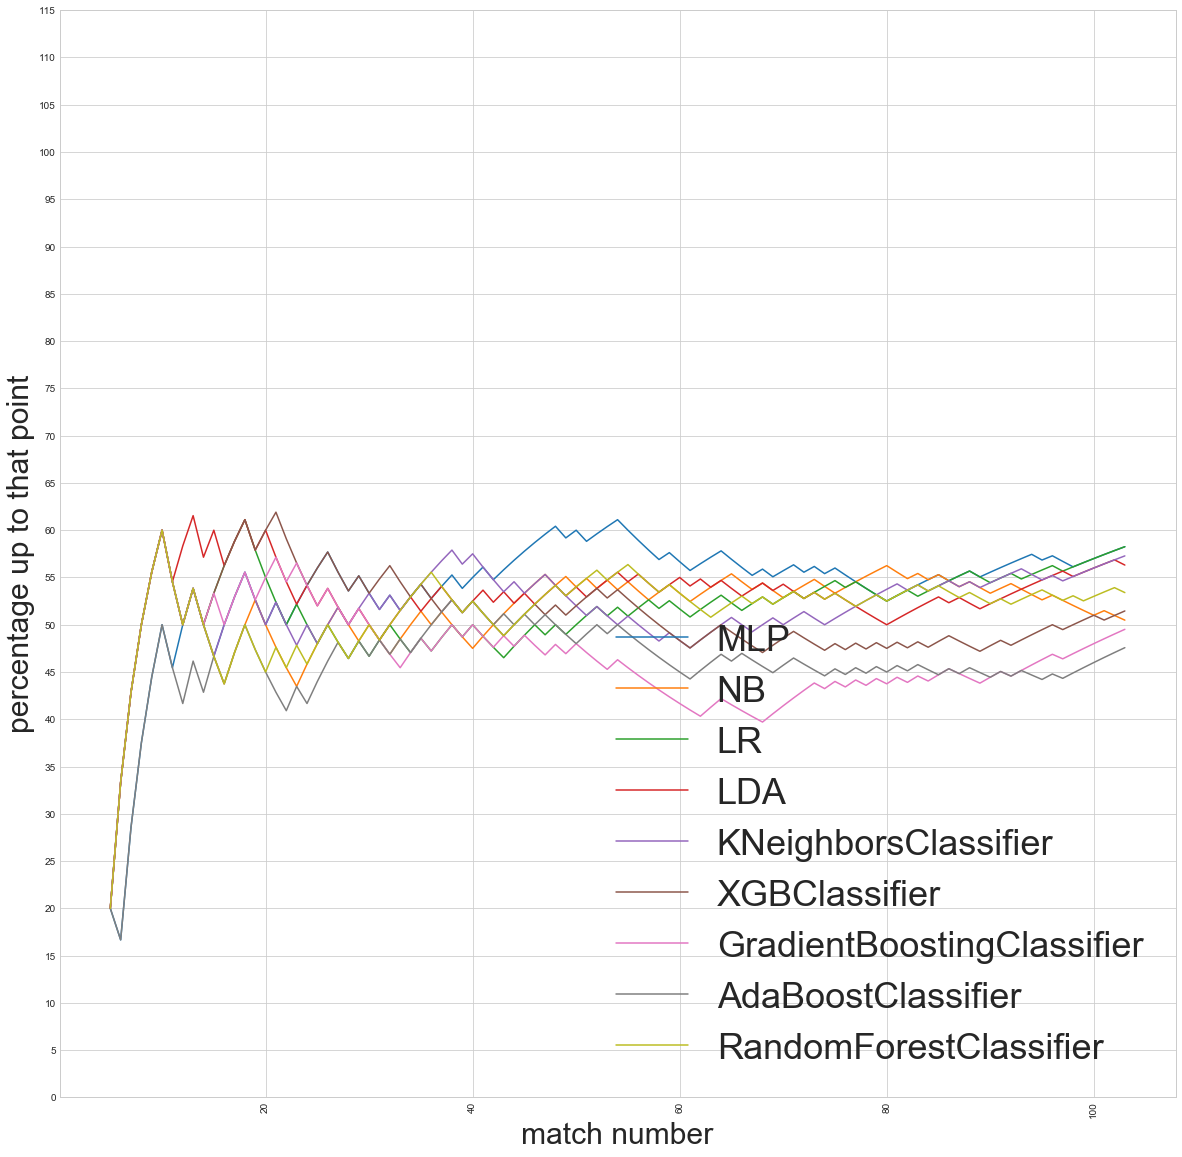

In [565]:
plt.figure(figsize=(20, 20))# people who registered on that day
plt.plot(g_scores.index, g_scores.MLP.values/g_scores.index * 100, label = 'MLP' )
plt.plot(g_scores.index, g_scores.NB.values/g_scores.index * 100, label = 'NB' )
plt.plot(g_scores.index, g_scores.LR.values/g_scores.index* 100, label = 'LR')
plt.plot(g_scores.index, g_scores.LDA.values/g_scores.index* 100,label = 'LDA')
plt.plot(g_scores.index, g_scores.KNeighborsClassifier.values/g_scores.index* 100, label = 'KNeighborsClassifier' )
plt.plot(g_scores.index, g_scores.XGBClassifier.values/g_scores.index* 100, label = 'XGBClassifier')
plt.plot(g_scores.index, g_scores.GradientBoostingClassifier.values/g_scores.index* 100,label = 'GradientBoostingClassifier')
plt.plot(g_scores.index, g_scores.AdaBoostClassifier.values/g_scores.index* 100, label = 'AdaBoostClassifier' )
plt.plot(g_scores.index, g_scores.RandomForestClassifier.values/g_scores.index* 100, label = 'RandomForestClassifier')
#plt.plot(g_scores.index, g_scores.ExtraTreesClassifier.values/g_scores.index* 100,label = 'ExtraTreesClassifier')
#plt.plot(g_scores.index, g_scores.DecisionTreeClassifier.values/g_scores.index* 100,label = 'DecisionTreeClassifier')
plt.legend(loc='lower right',prop={'size': 36})
plt.yticks(np.arange(0, 120, 5))
plt.xticks(rotation='vertical')
plt.ylim(ymin=0)
plt.xlabel('match number',size =30)
plt.ylabel('percentage up to that point',size = 30)


In [493]:
new_new_new_new_X.columns

Index([u'round_5', u'round_6', u'round_13', u'round_15', u'Nuke_round_9',
       u'Nuke_round_12', u'Overpass_round_2', u'Overpass_round_7',
       u'Overpass_round_14', u'Mirage_round_1', u'Mirage_round_4',
       u'Mirage_round_6', u'Mirage_round_7', u'Inferno_round_2',
       u'Inferno_round_4', u'Inferno_round_10', u'Train_round_4',
       u'Train_round_5', u'Train_round_7', u'Train_round_9', u'Train_round_10',
       u'Cache_round_3', u'Cache_round_5', u'Cache_round_7', u'Cache_round_8',
       u'Cache_round_12', u'Cobblestone_round_2', u'Cobblestone_round_3',
       u'Cobblestone_round_4', u'Cobblestone_round_5',
       u'Cobblestone_round_13'],
      dtype='object')

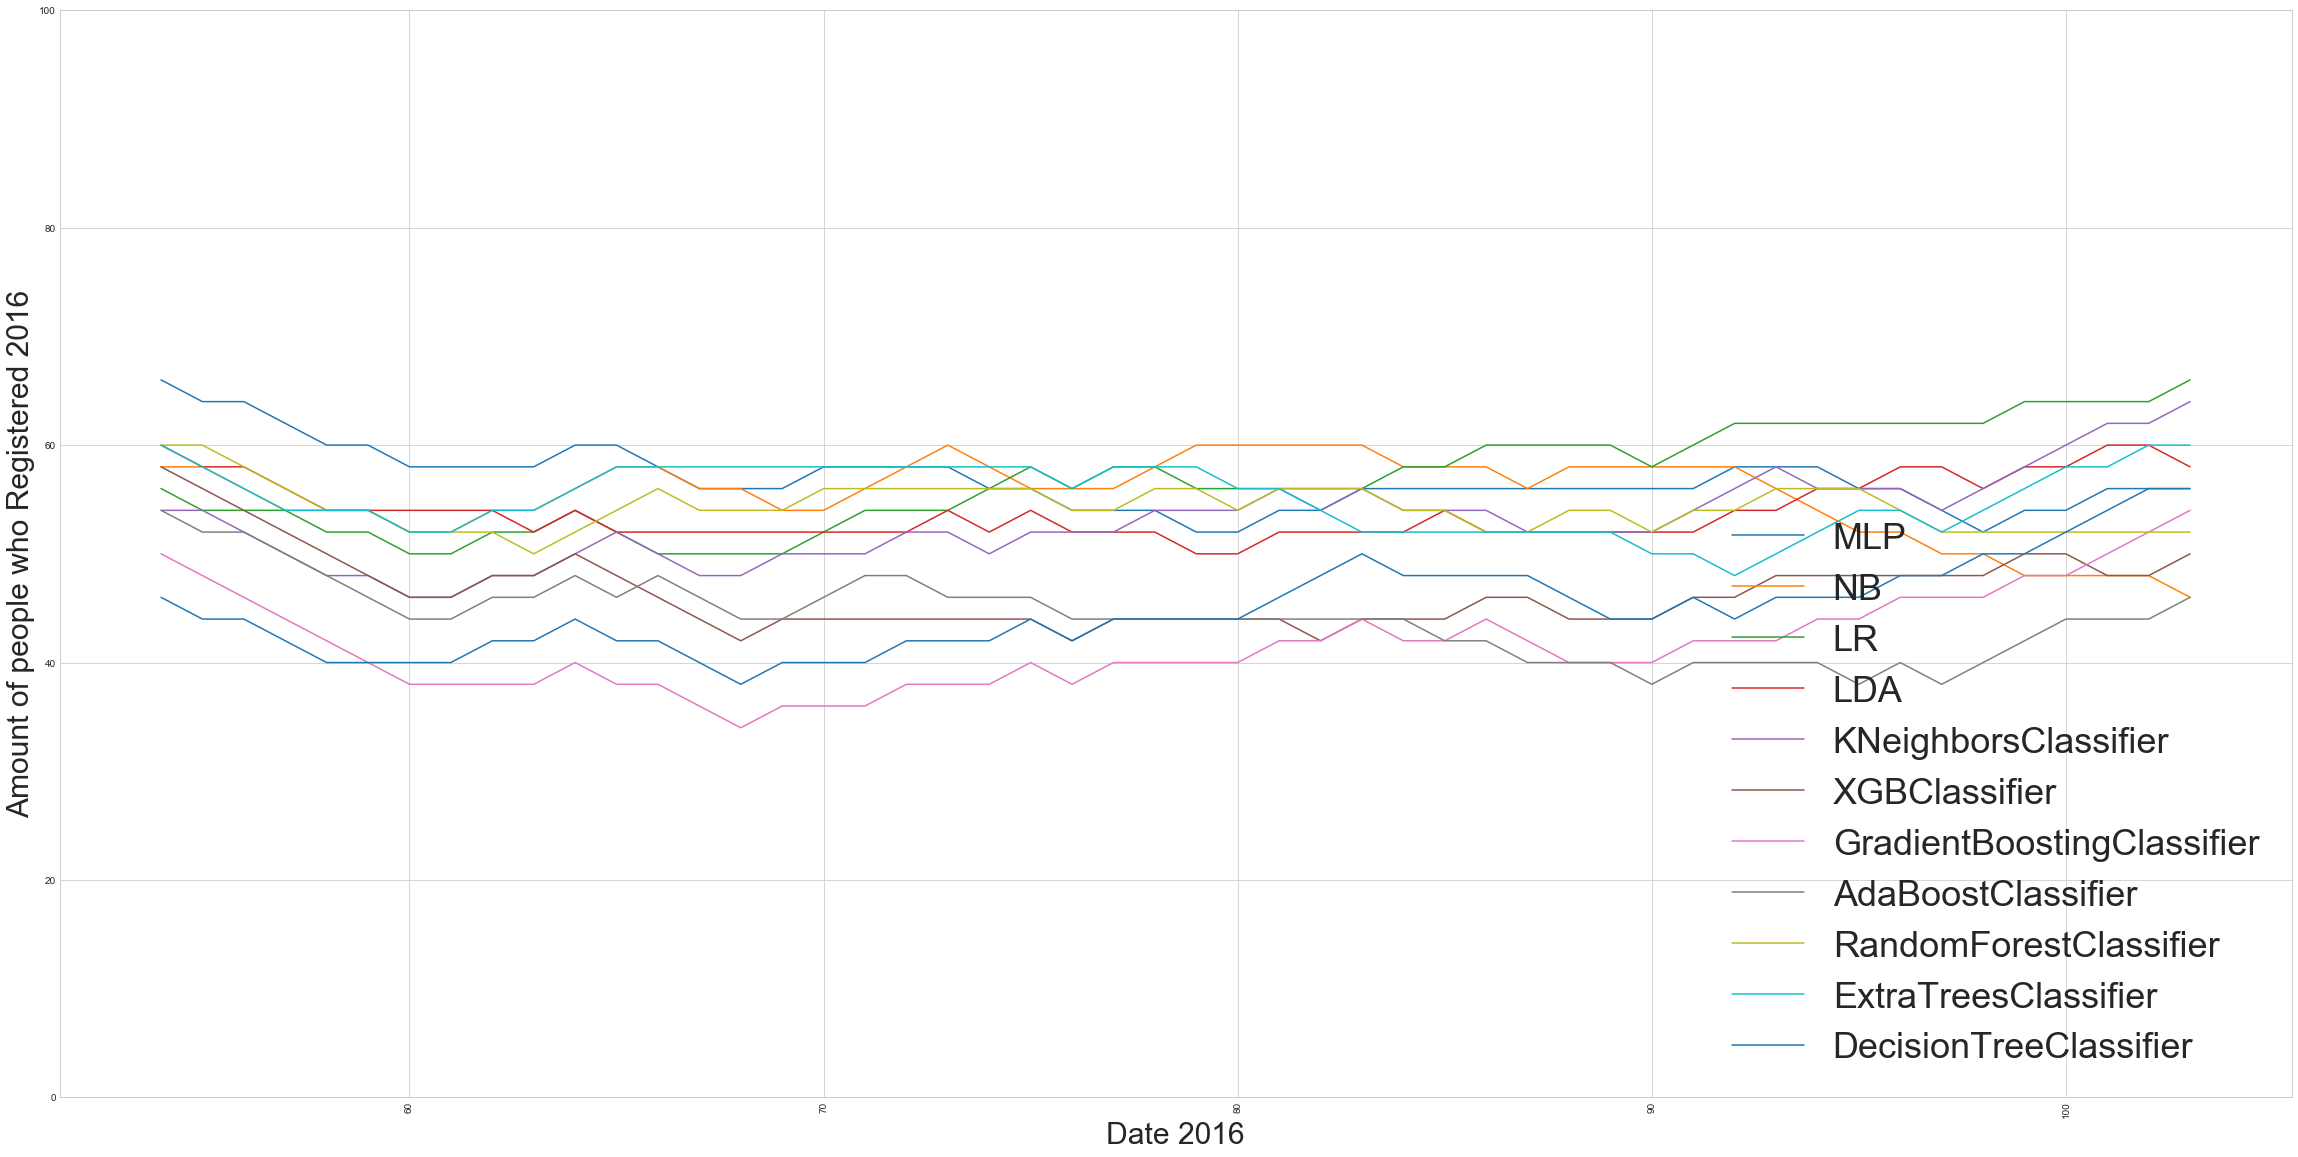

In [579]:
plt.figure(figsize=(40, 20))# people who registered on that day
plt.plot(big_scores.index, big_scores.MLP.values * 100, label = 'MLP' )
plt.plot(big_scores.index, big_scores.NB.values *100, label = 'NB' )
plt.plot(big_scores.index, big_scores.LR.values *100, label = 'LR')
plt.plot(big_scores.index, big_scores.LDA.values *100,label = 'LDA')
plt.plot(big_scores.index, big_scores.KNeighborsClassifier.values *100, label = 'KNeighborsClassifier' )
plt.plot(big_scores.index, big_scores.XGBClassifier.values *100, label = 'XGBClassifier')
plt.plot(big_scores.index, big_scores.GradientBoostingClassifier.values *100,label = 'GradientBoostingClassifier')
plt.plot(big_scores.index, big_scores.AdaBoostClassifier.values *100, label = 'AdaBoostClassifier' )
plt.plot(big_scores.index, big_scores.RandomForestClassifier.values *100, label = 'RandomForestClassifier')
plt.plot(big_scores.index, big_scores.ExtraTreesClassifier.values *100,label = 'ExtraTreesClassifier')
plt.plot(big_scores.index, big_scores.DecisionTreeClassifier.values *100,label = 'DecisionTreeClassifier')
plt.legend(loc='top left',prop={'size': 36})
plt.yticks(np.arange(0, 120, 20))
plt.xticks(rotation='vertical')
plt.ylim(ymin=0)
plt.xlabel('Date 2016',size =30)
plt.ylabel('Amount of people who Registered 2016',size = 30)

In [483]:
estimator = LogisticRegression(random_state = seed)
rfe = RFE(estimator)
fit = rfe.fit(new_new_new_X,y)
print("Num of feature: %d") % fit.n_features_
#print("Selected features: %s") % fit.support_
print("Feature Ranking: %s") % fit.ranking_

Num of feature: 31
Feature Ranking: [20  4 24 10  1  1 15  8  1  1  1  1  3  1 14  9  1  1  1  1  6  1  1  1  1
 11  5  1 30  1  1  1  1  1  1  1  1  1  1  1  1  1  1 17 12  2 13  1 23 31
  7 16 22 29 18 25 27 26 32 19 21 28]


In [484]:
top_31_important_features = [] 
for b in range(0,len(fit.ranking_)):
    if fit.ranking_[b] == 1:
        top_31_important_features.append(new_new_new_X.columns[b])
        print b,new_new_new_X.columns[b]

4 round_5
5 round_6
8 round_13
9 round_15
10 Nuke_round_9
11 Nuke_round_12
13 Overpass_round_2
16 Overpass_round_7
17 Overpass_round_14
18 Mirage_round_1
19 Mirage_round_4
21 Mirage_round_6
22 Mirage_round_7
23 Inferno_round_2
24 Inferno_round_4
27 Inferno_round_10
29 Train_round_4
30 Train_round_5
31 Train_round_7
32 Train_round_9
33 Train_round_10
34 Cache_round_3
35 Cache_round_5
36 Cache_round_7
37 Cache_round_8
38 Cache_round_12
39 Cobblestone_round_2
40 Cobblestone_round_3
41 Cobblestone_round_4
42 Cobblestone_round_5
47 Cobblestone_round_13


In [198]:
estimator = xgb.XGBClassifier()
rfe = RFECV(estimator,cv = kfold)
fit = rfe.fit(X,y)
print("Num of feature: %d") % fit.n_features_
#print("Selected features: %s") % fit.support_
print("Feature Ranking: %s") % fit.ranking_

NameError: name 'kfold' is not defined

In [1054]:
for a in range(0, len(models)):
    model1 = models[a]
    for b in range(a+1, len(models)):
        model2 = models[b]
        for c in range(b+1, len(models)):
            model3 = models[c]
            estimators = []
            estimators.append(model1)
            estimators.append(model2)
            estimators.append(model3)
            ensemble = VotingClassifier(estimators, voting='soft')
            results = model_selection.cross_val_score(ensemble, X, y, cv=kfold, scoring= scoring)
            if results.mean() > .69:
                print(model1[0], model2[0], model3[0],results.mean(), results.std())

KeyboardInterrupt: 